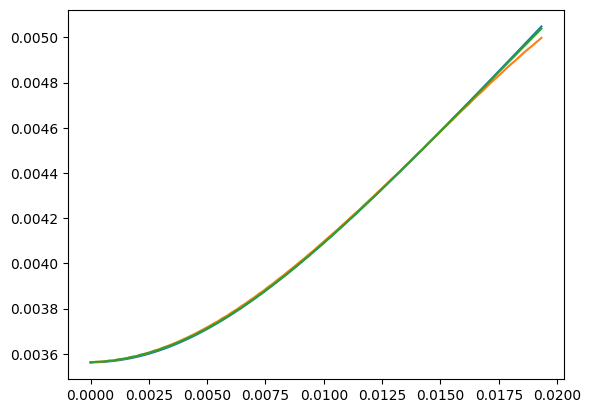

In [2]:
import matplotlib
import math

import matplotlib.pyplot as plt
from xsigmamodules.Util import (
    blackScholes,
    bachelier,
    dayCountConvention,
    day_count_convention_enum,
    datetimeHelper,
    sabrAnalytics,
    implied_volatility_enum,
    calendar,
    day_count_convention_enum,
    business_day_convention_enum,
)
from xsigmamodules.Math import normalDistribution, interpolation_enum
from xsigmamodules.Market import (
    discountCurveFlat,
    impliedVolatilitySmile,
    volatilityMarketData,
    marketRulesConfigBuilder,
    irVolatilityConfigBuilder,
    irVolatilitySabr,
    volatility_model_enum,
)
from xsigmamodules.util.misc import xsigmaGetDataRoot, xsigmaGetTempDir
from xsigmamodules.util.numpy_support import numpyToXsigma
import numpy as np


XSIGMA_DATA_ROOT = xsigmaGetDataRoot()
XSIGMA_TEST_ROOT = xsigmaGetTempDir()

ir_volatility_surface = irVolatilitySabr.read_from_json(
    XSIGMA_DATA_ROOT + "/Data/irVolatility.json"
)

market_rules = marketRulesConfigBuilder().with_holidays(calendar()).with_convention(day_count_convention_enum.ACT_365).with_adjustement(business_day_convention_enum.MODIFIED_FOLLOWING).with_settlement_days(2).build()
valuation_date = 43851.0

expiries = [
    "3y",
]
tenors = [
    "5y",
]

E = np.zeros(len(expiries))
M = np.zeros(len(tenors))
vol_matrix = np.zeros((len(expiries), len(tenors), 5))

vol_data = []
for i, e in enumerate(expiries):
    expiry_date = datetimeHelper.add_tenor(valuation_date, e)
    expiry = dayCountConvention().fraction(valuation_date, expiry_date)
    E[i] = expiry
    for j, T in enumerate(tenors):
        forward = 0.002
        maturity_date = datetimeHelper.add_tenor(expiry_date, T)
        model = ir_volatility_surface.model(expiry_date, maturity_date)

        M[j] = dayCountConvention().fraction(expiry_date, maturity_date)
        vol_atm = model.implied_volatility(
            forward, forward, expiry, implied_volatility_enum.NORMAL
        )
        vols = []
        strikes = []
        sqrt_expiry = math.sqrt(expiry)
        strikes_ratios = [
            1.0 - 4.0 * sqrt_expiry,
            1.0 - 2.5 * sqrt_expiry,
            1.0,
            1.0 + 2.5 * sqrt_expiry,
            1.0 + 4.0 * sqrt_expiry,
        ]
        for k, strike_ratio in enumerate(strikes_ratios):
            K = strike_ratio * forward
            strikes.append(K)
            vols.append(
                model.implied_volatility(
                    forward, K, expiry, implied_volatility_enum.NORMAL
                )
            )
        vol_data.append(impliedVolatilitySmile(e, T, forward, strikes, vols))

obj = volatilityMarketData(valuation_date, market_rules, vol_data)

standard_deviation = 7.0
minimum_vol_threshold = 0.0001
minimum_forward_shift = -0.03
pde_size = 100
time_steps = 5
skew_calibration_minimum_number_of_strikes = 3
time_interpolation_enum = interpolation_enum.LINEAR
strike_interpolation_enum = interpolation_enum.LINEAR
calibrate_backbone = False
calibrate_gamma_zabr = True
calibrate_shift = False
exclude_outlier_strikes = True

model_enum = volatility_model_enum.SABR_PDE
config = irVolatilityConfigBuilder()\
    .with_standard_deviation(standard_deviation)\
    .with_minimum_vol_threshold(minimum_vol_threshold)\
    .with_minimum_forward_shift(minimum_forward_shift)\
    .with_pde_size(pde_size)\
    .with_time_steps(time_steps)\
    .with_model_type(model_enum)\
    .with_min_strikes(skew_calibration_minimum_number_of_strikes)\
    .with_time_interpolation(time_interpolation_enum)\
    .with_strike_interpolation(strike_interpolation_enum)\
    .with_calibrate_backbone(calibrate_backbone)\
    .with_calibrate_gamma_zabr(calibrate_gamma_zabr)\
    .with_calibrate_shift(calibrate_shift)\
    .with_exclude_outlier_strikes(exclude_outlier_strikes)\
    .build()
volatilitydata_pde = irVolatilitySabr(obj, config)

model_enum = volatility_model_enum.SABR_ANALYTIC
config = irVolatilityConfigBuilder()\
    .with_standard_deviation(standard_deviation)\
    .with_minimum_vol_threshold(minimum_vol_threshold)\
    .with_minimum_forward_shift(minimum_forward_shift)\
    .with_pde_size(pde_size)\
    .with_time_steps(time_steps)\
    .with_model_type(model_enum)\
    .with_min_strikes(skew_calibration_minimum_number_of_strikes)\
    .with_time_interpolation(time_interpolation_enum)\
    .with_strike_interpolation(strike_interpolation_enum)\
    .with_calibrate_backbone(calibrate_backbone)\
    .with_calibrate_gamma_zabr(calibrate_gamma_zabr)\
    .with_calibrate_shift(calibrate_shift)\
    .with_exclude_outlier_strikes(exclude_outlier_strikes)\
    .build()
volatilitydata_analytic = irVolatilitySabr(obj, config)

model_enum = volatility_model_enum.ZABR_CLASSIC
config = irVolatilityConfigBuilder()\
    .with_standard_deviation(standard_deviation)\
    .with_minimum_vol_threshold(minimum_vol_threshold)\
    .with_minimum_forward_shift(minimum_forward_shift)\
    .with_pde_size(pde_size)\
    .with_time_steps(time_steps)\
    .with_model_type(model_enum)\
    .with_min_strikes(skew_calibration_minimum_number_of_strikes)\
    .with_time_interpolation(time_interpolation_enum)\
    .with_strike_interpolation(strike_interpolation_enum)\
    .with_calibrate_backbone(calibrate_backbone)\
    .with_calibrate_gamma_zabr(calibrate_gamma_zabr)\
    .with_calibrate_shift(calibrate_shift)\
    .with_exclude_outlier_strikes(exclude_outlier_strikes)\
    .build()
volatilitydata_zabr = irVolatilitySabr(obj, config)

expiry = "3Y"
tenor = "5Y"
expiry_date = datetimeHelper.add_tenor(valuation_date, expiry)
maturity_date = datetimeHelper.add_tenor(expiry_date, tenor)

model_pde = volatilitydata_pde.model(expiry_date, maturity_date)
model_analytic = volatilitydata_analytic.model(expiry_date, maturity_date)
model_zabr = volatilitydata_zabr.model(expiry_date, maturity_date)


expiry = dayCountConvention().fraction(valuation_date, expiry_date)
sqrt_expiry = math.sqrt(expiry)
n = 100
strikes = np.linspace(0.0, forward + forward * 5.0 * sqrt_expiry, n)
vols_analytic = []
vols_pde = []
vols_zabr = []
for K in strikes:
    vols_analytic.append(
        model_analytic.implied_volatility(
            forward, K, expiry, implied_volatility_enum.NORMAL
        )
    )
    vols_pde.append(
        model_pde.implied_volatility(forward, K, expiry, implied_volatility_enum.NORMAL)
    )
    vols_zabr.append(
        model_zabr.implied_volatility(
            forward, K, expiry, implied_volatility_enum.NORMAL
        )
    )

plt.plot(strikes, vols_analytic)
plt.plot(strikes, vols_pde)
plt.plot(strikes, vols_zabr)
plt.show()
